# Week 7 of Introduction to Biological System Design
## Stochastic Systems and Simulations
### Ayush Pandey

Pre-requisite: To get the best out of this notebook, make sure that you have basic understanding of probability distributions. For more information on probability theory you may refer to any standard book on engineering math. The notebook uses ODE models to evaluate stochasticity effects as well. You can learn more about how to numerically simulate ODEs deterministically from the [week3_intro_ode.ipynb](https://pages.hmc.edu/pandey/reading/week3_intro_ode.ipynb) notebook. Further, it is also assumed that you have a working knowledge of gene expression processes, use of Hill functions for gene regulation, and biological system motifs. Computational examples with Hill functions are discussed in [week4_hill_functions.ipynb](https://pages.hmc.edu/pandey/reading/week4_hill_functions.ipynb) whereas design choices underlying biological motifs are shown in [week6_system_analysis.ipynb](https://pages.hmc.edu/pandey/reading/week6_system_analysis.ipynb).

This notebook presents stochatic simulations of biological systems and processes such as cell division, gene expression and gene regulation. The physical effects of randomness and noise in these simulations is also alluded to in the notebook with the help of examples.

# Stochastic Cell Division

Consider a mother cell with $N$ molecules which divides into two daughter cells with $n_1$ and $n_2$ molecules. Let the probability of a molecule being in daughter 1 be given by $p$ and the probability of a molecule in daughter 2 be $q$. Then, we have $p + q = 1$. The probability distribution that models this "random" cell division is called the Binomial distribution and is given by,

$ \mathbb{P}(n_1, N) = \left(\begin{matrix}N \\ n_1\end{matrix}\right) p^{n_1} q^{N - n_1}$ 

where $\left(\begin{matrix}N \\ n_1\end{matrix}\right)$ represents "$N$ choose $n_1$", that is the number of possibilities of choosing $n_1$ molecules from $N$ total. 

The binomial distribution is a simplest stochastic model of cell division but can be effectively used to model cell lineage growth. To simulate this process, we can take a "Monte Carlo Sampling" approach, where we simulate the binomial distribution such that for every molecule we draw a random sample and propagate its place in one of the daughter cells, and so on. 

The mean of the binomial distribution is given by $\mu = Np$ and the variance is given by $\sigma^2 = Npq$. The coefficient of variation (CV) can be used to determine the variation from the mean and is given by $\sigma/\mu$. If CV is low, a deterministic approximation may work fine but for high CV, we need to simulate the system stochastically. 

Let us use Python to run a stochastic model of cell division:

## Using binomial distribution for cell division

### Simulate coin flips

In [5]:
import numpy as np

n, p = 10, .5  # number of trials, probability of each trial

s = np.random.binomial(n, p, 1000)
# result of flipping a coin 10 times, tested 1000 times.

In [7]:
# Print out s to see the samples
# s

### Simulate cell division with N = 100 molecules

In [29]:
p = 0.5 # probability of each molecule to go to daughter 1
N = 100 #number of molecules in each cell
number_of_cells = 10000
daughter_1_cells = np.random.binomial(N, p, number_of_cells)
q = 1 - p
daughter_2_cells = np.random.binomial(N, q, number_of_cells)

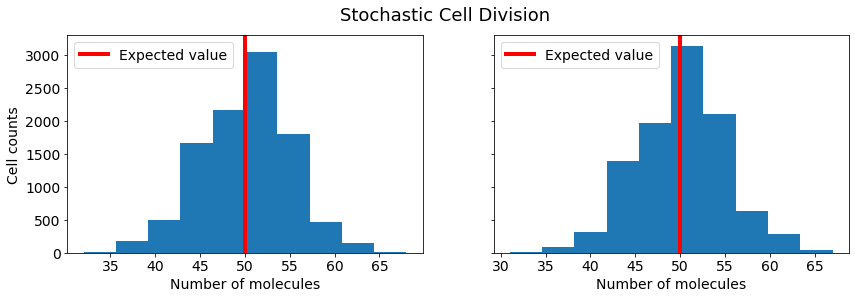

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (14,4), sharey = True)
fig.suptitle('Stochastic Cell Division', fontsize = 18)
ax[0].hist(daughter_1_cells)
ax[0].axvline(N*p, color = 'red', lw = 4, label = 'Expected value')
ax[0].set_xlabel('Number of molecules', fontsize = 14)
ax[0].set_ylabel('Cell counts', fontsize = 14)
ax[0].tick_params(labelsize = 14)
ax[0].legend(fontsize = 14)

ax[1].hist(daughter_2_cells)
ax[1].axvline(N*q, color = 'red', lw = 4, label = 'Expected value')
ax[1].set_xlabel('Number of molecules', fontsize = 14)
ax[1].tick_params(labelsize = 14)
ax[1].legend(fontsize = 14);

In [61]:
def divide_cell(N, p):
    """
    Given a cell with N molecules, divide it 
    into two daughter cells according to Binomial
    distribution with probability p
    """
    d1 = np.random.binomial(N, p)
    d2 = N - d1
    return d1, d2

N0 = 1 # start with 1 cell
generations = 20 # cell division cycles
d1 = np.zeros(generations)
d2 = np.zeros(generations)
for g in range(generations):
    d1[g], d2[g] = divide_cell(N, p)

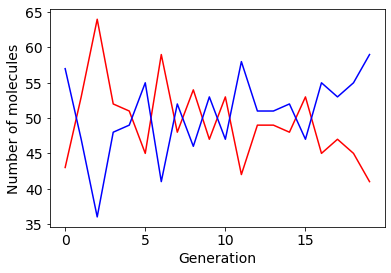

In [66]:
ax = plt.axes()
ax.plot(d1, 'r')
ax.plot(d2, 'b')
ax.set_ylabel('Number of molecules', fontsize = 14)
ax.set_xlabel('Generation', fontsize = 14)
ax.tick_params(labelsize = 14)

# Stochastic Simulation Algorithm (SSA)

It is often the case that the analytical probability distribution of processes is unknown. In such cases, quantifying the stochastic behavior can be challenging. Stochastic simulation algorithms are built to simulate system descriptions (rate equations, chemical reactions, etc.) in a stochastic manner. We will build a very basic stochastic simulator in this notebook to simulate gene expression. For an unregulated gene, we can write a one-state model:

$\frac{dX}{dt} = k - dX$

In deterministic simulations, we assume that the number of molecules of $X$ are high enough so that we can approximate its dynamics by modeling the concentration. However, in reality, we have the count of molecules of $X$ which is increasing or decreasing stochastically. So, let us model the unregulated gene expression by using number of molecules of $X$ as our state variable. 

Let $\mathbb{P}(X,t)$ be the probability that there are $X$ molecules of protein $X$ at time $t$. We define that this probability will be equal to zero if $X < 0$. For $X > 0$, we can write the following for change in $X$:

$X - 1 \rightarrow X$, propensity = $k$,

$X + 1 \rightarrow X$, propensity = $d(X+1)$,

$X \rightarrow X + 1$, propensity = $k$,

$X \rightarrow X - 1$, propensity = $dX$.

The propensity defines the transition probability, that is, the probability of transitioning from $X$ molecules to $X+1$ molecules is given by the rate $k$, similarly, to degrade from $X$ to $X - 1$, we have the transition probability defined as $dX$. 

We can then define the following equation for change of probability of the number of protein molecules $X$ at time $t$,

$\frac{d\mathbb{P}(X, t)}{dt} = k\mathbb{P}(X-1, t) + d  (X + 1)  \mathbb{P}(X+1, t) - k\mathbb{P}(X, t) - d  X  \mathbb{P}(X, t)$

The first two terms define the ways in which we get to the microstate with $X$ molecules and the last two terms define the ways in which we transition out of the microstate with $X$ molecules. 
